In [60]:
import xml.etree.cElementTree as ET
import pprint
import re
from collections import defaultdict
from IPython.display import display
import operator
import codecs
import json

import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Intro
For this project, I chose the San Francisco Bay Area.

In [2]:
OSM_FILE = 'san-francisco-bay_california.osm'
#OSM_FILE = "sample-k-10.osm"
#OSM_FILE = "sample-k-100.osm"

street_type_re = re.compile(r'(\b\S+\.?)$', re.IGNORECASE) # "300 Bernal Ave." or "900 Cy Ranch Drive"
street_type_num_re = re.compile(r'(\b\S+\.?)(?= #?[0-9]+$)', re.IGNORECASE) # "20 Cal Avenue #32" or "15 Stevens Creek Hwy 2"

In [3]:
# Examples of using street_type_num_re
m = street_type_num_re.search("2030 Hwy 1")
print(m.group(1))

m = street_type_num_re.search("Old Bernal Ave #1")
print(m.group(1))

Hwy
Ave


In [4]:
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

In [5]:
def count_high_level_tags(filename):
    tags = defaultdict(int)
    
    #for i, elem in enumerate(get_element(OSM_FILE)):
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        tags[elem.tag] += 1
        
        # TODO(hkwik): I know I ought to clear the root, but not sure about elem.tag in tags.
        # Once I understand, I'll put this in.
        # if event == 'end' and elem.tag in tags: 
        #    root.clear()
    
    return tags

count_high_level_tags(OSM_FILE)

defaultdict(int,
            {'bounds': 2,
             'member': 199832,
             'nd': 28718262,
             'node': 24541624,
             'osm': 2,
             'relation': 22116,
             'tag': 11056318,
             'way': 2596034})

# Data Wrangling
To come up with ideas for parts of the data to clean, I looked at the distribution of keys in the dataset. I also audited street names, zip codes, and counties.

## Audit Keys


In [6]:
def count_keys(tag, keys):
    k = tag.attrib['k']
    keys[k] += 1
    pass

def audit_keys(osm_file):
    keys = defaultdict(int)
    for i, elem in enumerate(get_element(osm_file, tags=['node', 'way'])):
        for tag in elem.iter('tag'):
            count_keys(tag, keys)
    
    #osm_file.close()
    return keys

In [7]:
keys = audit_keys(OSM_FILE)

sorted_keys = sorted(keys.items(), key=operator.itemgetter(1))
sorted_keys[::-1]

[('building', 769773),
 ('highway', 450609),
 ('name', 298877),
 ('addr:housenumber', 226713),
 ('addr:street', 216430),
 ('tiger:county', 208752),
 ('tiger:cfcc', 198422),
 ('addr:city', 185842),
 ('tiger:name_base', 179842),
 ('source', 172561),
 ('tiger:name_type', 169963),
 ('tiger:reviewed', 144771),
 ('tiger:zip_left', 140678),
 ('tiger:zip_right', 133904),
 ('tiger:tlid', 95921),
 ('tiger:source', 95492),
 ('addr:state', 92623),
 ('tiger:separated', 90630),
 ('addr:postcode', 75539),
 ('oneway', 69357),
 ('height', 62744),
 ('amenity', 51016),
 ('service', 49919),
 ('created_by', 45631),
 ('lanes', 43212),
 ('landuse', 38887),
 ('waterway', 38661),
 ('power', 30175),
 ('maxspeed', 29213),
 ('tiger:upload_uuid', 28703),
 ('surface', 27185),
 ('bicycle', 26295),
 ('natural', 24853),
 ('paloalto_ca:id', 24799),
 ('leisure', 21511),
 ('access', 19506),
 ('ref', 18693),
 ('redwood_city_ca:bld_gid', 18646),
 ('nhd:reach_code', 17540),
 ('cycleway', 17525),
 ('foot', 17476),
 ('layer',

## Audit Addresses

### Street Names
The `mapping` dictionary below shows the types of cleaning I fixed. There were a variety of typos and abbreviations for street names. For street names, I went further and also fixed abbreviations that occured before a number sign, e.g. "Old Bernal Ave #5."

### Post Codes
I found two types of errors with post codes:

1. The entire address listed in the post code. "1 Donner St, San Juan Bautista, CA 95045." We can simply extract the postcode from this string.
2. Address information, but no post code, e.g. "950 San Felipe Rd, San Benito County, CA, -." Since there is no postcode information, I ignored cases like these.

Other than these errors, postcodes in the dataset appeared to be pretty good!

### Counties
The most common error I found and fixed was county fields that had the word "county" in them, e.g. "San Benito County."

In [8]:
expected = ["Alley", "Avenue", "Boulevard", "Center", "Circle", "Common", "Commons", 
            "Corte", "Court", "Courtyard", "Drive", "Expressway", 
            "Highway", "Lane", "Loop", "Mall", "Path", "Park", "Parkway", "Place", "Plaza",
            "Real", "Road", "Square", "Street", "Terrace", "Trail", "Walk",
            "Way"]

mapping = { "Aly": "Alley",
            "avenue": "Avenue",
            "AVE": "Avenue",
            "Ave": "Avenue",
            "Aveenue": "Avenue",
            "Avenie": "Avenue",
            "Ave.": "Avenue",
            "blvd": "Boulevard",
            "BLVD.": "Boulevard",
            "BLVD": "Boulevard",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Boulvevard": "Boulevard",
            "Boulevar": "Boulevard",
            "Cir": "Circle",
            "Circle:": "Circle",
            "court": "Court",
            "Ct": "Court",
            "Ct.": "Court",
            "Ctr": "Center",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Expwy": "Expressway",
            "Hwy": "Highway",
            "Hwy.": "Highway",
            "Ln": "Lane",
            "Ln.": "Lane",
            "parkway": "Parkway",
            "PKWY": "Parkway",
            "PL": "Place",
            "Pl": "Place",
            "PT": "Point",
            "road": "Road",
            "Rd": "Road",
            "Rd.": "Road",
            "st": "Street",
            "St": "Street",
            "St.": "Street",
            "street": "Street",
            "terrace": "Terrace",
            "way": "Way",
            "WAy": "Way"
            }

In [9]:
def audit_street_type_regex(street_types, regex, street_name):
    # Assume group(1) contains the street type
    m = regex.search(street_name)
    if m:
        street_type = m.group(1)
        if street_type not in expected and street_type not in mapping:
            street_types[street_type].add(street_name)

def audit_street_type(street_types, street_name):
    audit_street_type_regex(street_types, street_type_re, street_name)
    audit_street_type_regex(street_types, street_type_num_re, street_name)
    
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def is_postcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def is_county(elem):
    return (elem.attrib['k'] == "addr:county")

def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    postcodes = defaultdict(int)
    counties = defaultdict(int)
    
    for i, elem in enumerate(get_element(osm_file)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                k = tag.attrib['k']
                v = tag.attrib['v']
                
                if is_street_name(tag):
                    audit_street_type(street_types, v)
                
                if is_postcode(tag):
                    postcodes[v] += 1
                    
                if is_county(tag):
                    counties[v] += 1
                    
    osm_file.close()
    return street_types, postcodes, counties


def update_name(name, mapping):
    m = street_type_re.search(name)
    if m:
        street_type = m.group()
        new_street_type = mapping[street_type]
        name = re.sub(street_type_re, new_street_type, name)
    return name

In [10]:
street_types, post_codes, counties = audit(OSM_FILE)

In [11]:
street_types

defaultdict(set,
            {'0.1': {'Ala 680 PM 0.1'},
             '1': {'10795 Hwy 1',
              '2030 Hwy 1',
              'California Highway 16, House No. 1',
              'Old Bernal Ave #1',
              'Prospect Rd #1',
              'State Hwy 1',
              'Stewart Drive Suite #1',
              'W Of Us 101 @ Jct Sr 1'},
             '10': {'San Mateo 35 PM 10', 'South St #10'},
             '100': {'Northgate Blvd #100', 'Woodside Road, Suite 100'},
             '101': {'Highway 101',
              'Nw Quad Lincoln Ave / Us 101',
              'Se Quad Smith Ranch Rd / Us 101'},
             '102': {'County Road 102'},
             '105': {'N California Blvd #105'},
             '10675': {'10675'},
             '11': {'Fairview Rd #11'},
             '110': {'West Angela Street, Suite 110'},
             '110,': {'Promenade Circle #110,'},
             '114': {'West Evelyn Avenue Suite #114'},
             '116': {'Hwy 116',
              'In "Y" Jct Of Sr 121

In [12]:
[k for k in post_codes if len(k) > 10]

['17 Via Padre, San Benito County, CA, -',
 '1371 Westside Blvd, Hollister, CA 95023',
 '660 Westside Blvd, Hollister, CA 95023',
 '18 Monterey St, San Juan Bautista, CA 95045',
 '200 Western Ct, Hollister, CA 95023',
 '1600 Citation Way, Hollister, CA 95023',
 '17 Ahwahnee St, San Juan Bautista, CA 95045',
 '439 Snyder Ave, Aromas, CA 95004',
 '1123 1st St, San Juan Bautista, CA 95045',
 '981 Prospect Ave, Hollister, CA 95023',
 '32 Via Padre',
 '293 Westside Blvd, Hollister, CA 95023',
 '2900 Fairview Rd, Hollister, CA 95023',
 '71 Westside Blvd, Hollister, CA 95023',
 '171 Westside Blvd, Hollister, CA 95023',
 '23 Ahwahnee St, San Juan Bautista, CA 95045',
 '2 Donner St, San Juan Bautista, CA 95045',
 '270 Prater Way, Hollister, CA 95023',
 '121 Westside Blvd, Hollister, CA 95023',
 '340 Prater Way, Hollister, CA 95023',
 '1 Donner St, San Juan Bautista, CA 95045',
 '710 Kirkpatrick Dr, Hollister, CA 95023',
 '38 Monterey St, San Juan Bautista, CA 95045',
 '283 Willow Dr, Hollister,

In [13]:
counties

defaultdict(int,
            {'Alameda': 261,
             'Amador': 2,
             'Contra Costa': 906,
             'El Dorado': 36,
             'Lake': 10,
             'Marin': 873,
             'Merced': 50,
             'Monterey': 161,
             'Monterey, CA': 1,
             'Napa': 248,
             'Sacramento': 1013,
             'San Benito': 179,
             'San Benito County': 6694,
             'San Joaquin': 1258,
             'San Mateo': 162,
             'Santa Clara': 1689,
             'Santa Clara County': 4,
             'Santa Cruz': 3,
             'Solano': 892,
             'Sonoma': 15,
             'Stanislaus': 454,
             'Yolo': 789})

## Cleaning

In [14]:
def update_street_name_regex(regex, name, mapping):
    m = regex.search(name)
    if m:
        street_type = m.group(1)
        new_street_type = mapping.get(street_type)
        if new_street_type:
            name = re.sub(regex, new_street_type, name)
            return name
    
    return name

def update_street_name(name, mapping):
    new_name = update_street_name_regex(street_type_re, name, mapping)
    if new_name != name:
        return new_name
    
    new_name = update_street_name_regex(street_type_num_re, name, mapping)
    if new_name != name:
        return new_name
    
    return name

postcode_re = re.compile(r'[0-9]{5,5}$', re.IGNORECASE)
postcode_dash_re = re.compile(r'[0-9]{5,5}-[0-9]{4,4}$', re.IGNORECASE)

def has_valid_postcode(name):
    return postcode_re.search(name) is not None or postcode_dash_re.search(name) is not None

def update_postcode(name):
    m = postcode_re.search(name)
    if m is None:
        m = postcode_dash_re.search(name)
    return m.group()

county_re = re.compile(r'(.+) County', re.IGNORECASE)

def update_county(name):
    m = county_re.search(name)
    if m:
        name = m.group(1)
    return name

In [15]:
postcode1 = "94588"
postcode2 = "94588-1234"
address = "1 Donner St, San Juan Bautista, CA 95045"
address2 = "950 San Felipe Rd, San Benito County, CA, -"

postcode_re = re.compile(r'[0-9]{5,5}$', re.IGNORECASE)
postcode_dash_re = re.compile(r'[0-9]{5,5}-[0-9]{4,4}$', re.IGNORECASE)

In [16]:
update_postcode(address)

'95045'

In [17]:
display(update_street_name("2nd st", mapping))
display(update_street_name("Northgate Blvd #100", mapping))

'2nd Street'

'Northgate Boulevard #100'

In [18]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = ["version", "changeset", "timestamp", "user", "uid"]
POSITION = ["lat", "lon"]

def has_lat_lon(element):
    return 'lat' in element.attrib and 'lon' in element.attrib

def shape_attributes(element, node):
    for attr in element.attrib:
        if attr in CREATED or attr in POSITION:
            continue
        node[attr] = element.attrib[attr]
        #print attr, element.attrib[attr]
    
    created = {}
    for attr in CREATED:
        if attr in element.attrib:
            created[attr] = element.attrib[attr]
    node['created'] = created
    
    if has_lat_lon(element):
        node['pos'] = [float(element.attrib['lat']), float(element.attrib['lon'])]

def shape_tags(element, node):
    address = {}
    for tag in element.iter("tag"):
        key = tag.attrib['k']
        value = tag.attrib['v']
        
        if is_street_name(tag):
            value = update_street_name(value, mapping)
        
        if is_postcode(tag):
            if not has_valid_postcode(value):
                continue
            value = update_postcode(value)
        
        if is_county(tag):
            value = update_county(value)
                    
        #print key, value
        if (re.search(problemchars, key) or 
            (re.search(lower, key) is None and 
            re.search(lower_colon, key) is None)):
            continue
        
        if re.search(lower_colon, key):
            key_arr = key.split(':')
            prefix = key_arr[0]
            suffix = key_arr[1]
            
            if prefix == 'addr':
                address[suffix] = value
            else:
                key = re.sub(':', "-", key)
                node[key] = value
                
            continue
        
        node[key] = value
    
    if len(address) > 0:
        #print node
        node['address'] = address    

def shape_node_refs(element, way):
    refs = []
    if element.tag == "way":
        for nd in element.iter("nd"):
            refs.append(nd.attrib['ref'])
        way['node_refs'] = refs
    
def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way" :
        # Handle top-level element
        node['type'] = element.tag
        
        shape_attributes(element, node)   
        
        # Handle tags
        shape_tags(element, node)
        
        # Handle node refs for way
        shape_node_refs(element, node)
        
        #print node
        return node
    else:
        return None

In [23]:
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        
        for i, elem in enumerate(get_element(file_in)):
            el = shape_element(elem)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

In [24]:
process_map(OSM_FILE, True)

[{'created': {'changeset': '22950379',
   'timestamp': '2014-06-15T18:55:15Z',
   'uid': '1660455',
   'user': 'juergenb22',
   'version': '6'},
  'id': '281266',
  'pos': [37.5601845, -122.3025783],
  'type': 'node'},
 {'created': {'changeset': '3061377',
   'timestamp': '2009-11-08T08:11:05Z',
   'uid': '28775',
   'user': 'StellanL',
   'version': '8'},
  'id': '281393',
  'pos': [37.5280244, -122.2948711],
  'type': 'node'},
 {'created': {'changeset': '3061377',
   'timestamp': '2009-11-08T08:11:05Z',
   'uid': '28775',
   'user': 'StellanL',
   'version': '7'},
  'id': '281394',
  'pos': [37.5271055, -122.2978408],
  'type': 'node'},
 {'created': {'changeset': '3061377',
   'timestamp': '2009-11-08T08:11:05Z',
   'uid': '28775',
   'user': 'StellanL',
   'version': '7'},
  'id': '281395',
  'pos': [37.5265201, -122.3013256],
  'type': 'node'},
 {'created': {'changeset': '3061377',
   'timestamp': '2009-11-08T08:11:06Z',
   'uid': '28775',
   'user': 'StellanL',
   'version': '7'},

# Data Overview

## File Sizes

`san-francisco-bay_california.osm` is 2.5G and the corresponding JSON file, `san-francisco-bay_california.osm`, is 3.6G.

In [26]:
from pymongo import MongoClient

In [27]:
client = MongoClient('mongodb://localhost:27017')

In [28]:
db = client.osm

### Number of documents

In [29]:
db.sfbay.find().count()

13568829

In [31]:
# Number of nodes
db.sfbay.find({"type":"node"}).count()

12270667

In [32]:
# Number of ways
db.sfbay.find({"type":"way"}).count()

1297749

In [43]:
# Number of unique users
len(db.sfbay.distinct("created.user"))

5141

In [79]:
def aggregate(db, pipeline):
    return [doc for doc in db.sfbay.aggregate(pipeline)]

In [80]:
# User with the most records
group = {"$group":{"_id":"$created.user", "count":{"$sum":1}}}
sort = {"$sort":{"count":-1}}
limit = {"$limit": 1}
pipeline = [group, sort, limit]

aggregate(db, pipeline)
#db.sfbay.aggregate(pipeline)

[{u'_id': u'nmixter', u'count': 1728932}]

### Distribution of User Records
In the histogram below, we see a long tail of users who have contributed many records to the dataset.

,_id,count
0,nmixter,1728932
1,ediyes,1100022
2,Eureka gold,783478
3,Luis36995,783066
4,woodpeck_fixbot,642611


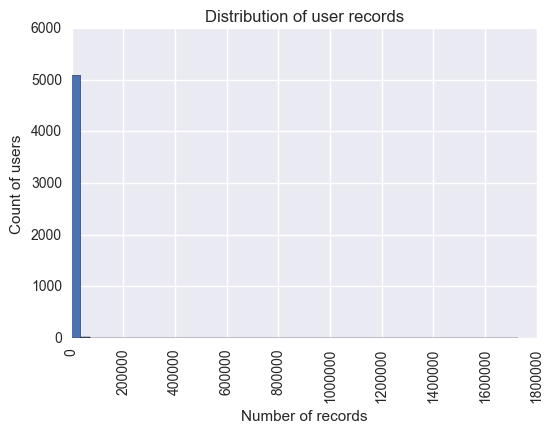

In [84]:
pipeline = [group, sort]
user_counts_df = pd.DataFrame(user_counts)
display(user_counts_df.head())

ax = user_count_df['count'].hist(xrot=90, bins=50)
ax.set_xlabel('Number of records')
ax.set_ylabel("Count of users")
ax.set_title("Distribution of user records");